In [1]:
import json
import csv
from langdetect import detect
import nltk
import re
import os
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from textblob import TextBlob

In [2]:
output_directory = '../comments/debate/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
data_directory = '../original_data/debate/'
# Load the json files from the data directory
files = os.listdir(data_directory)
json_files = [f for f in files if f.endswith('.json')]
json_files

['The Wall Street Journal-Full Debate: Biden and Trump in the First 2024 Presidential Debate | WSJ.json',
 'CNN-The must-watch moments of the CNN Presidential Debate.json']

In [3]:
def clean_text(text):
    # Remove emojis, special symbols, and extra whitespaces
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # remove punctuations
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    # Remove leading and trailing whitespaces
    cleaned_text = cleaned_text.strip()
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    return cleaned_text


def tokenize_text(text):
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    return tokens


def remove_stopwords(tokens):
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens


def lemmatize_tokens(tokens):
    # Lemmatize the tokens
    lemmatizer = nltk.stem.WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

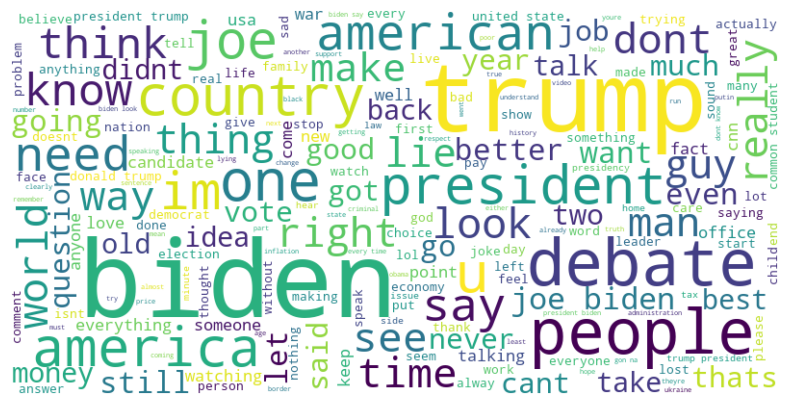

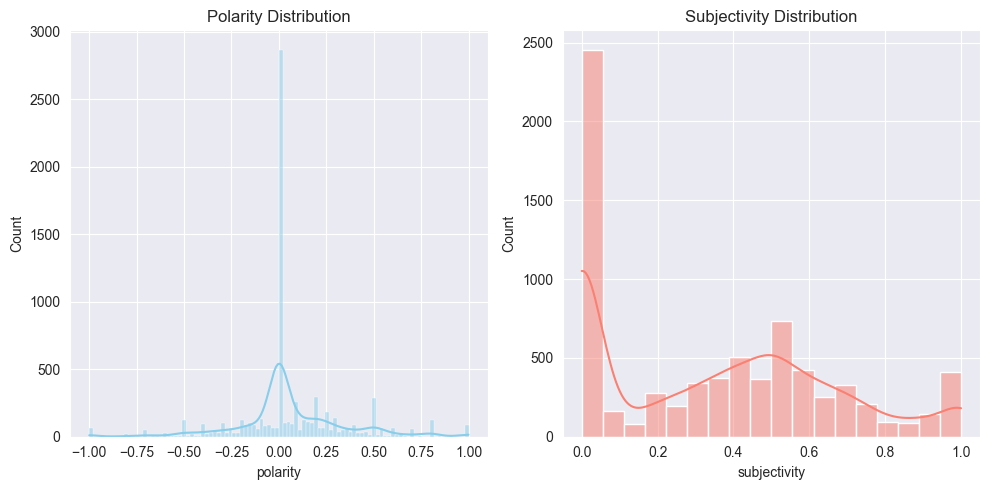

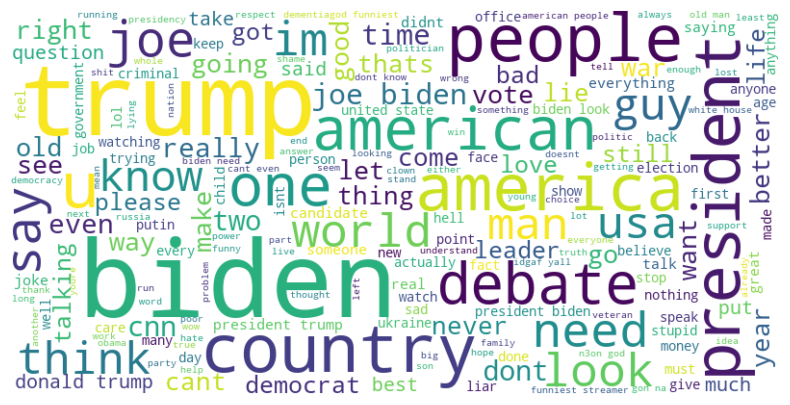

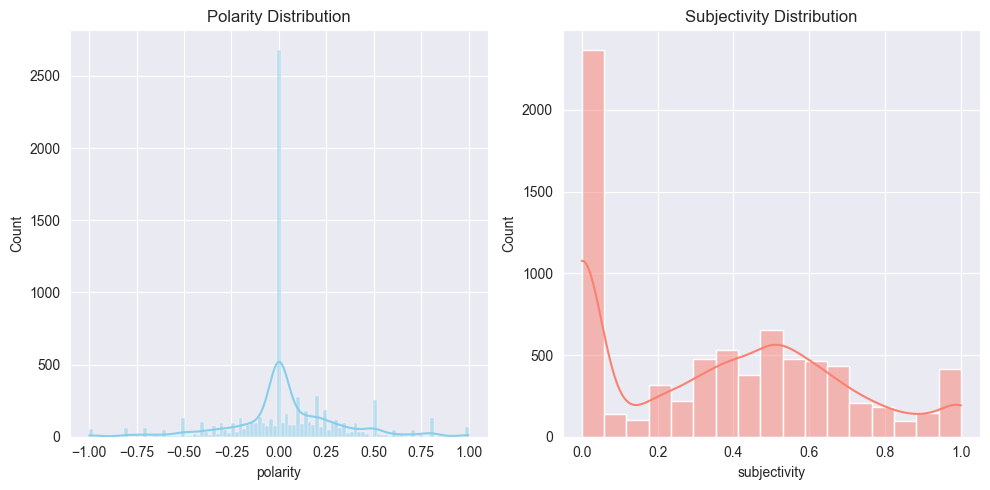

In [4]:
for json_file in json_files:
    with open(data_directory + json_file, 'r') as f:
        data = json.load(f)
    comments = data['video_comments']
    cleaned_comments = []
    for comment in comments:
        comment_text = comment['comment_text']
        try:
            lang = detect(comment_text)
            if lang == 'en':
                cleaned_comment = clean_text(comment_text)
                cleaned_comments.append(cleaned_comment)
        except:
            # If language detection fails, skip the comment
            pass

    # Save cleaned comments to a new CSV file, add a header
    with open(output_directory + "{}_cleaned.csv".format(json_file.split('.')[0]), 'w', newline='') as cleaned_csv_file:
        writer = csv.writer(cleaned_csv_file)
        writer.writerow(['comment'])
        for comment in cleaned_comments:
            writer.writerow([comment])
            
    tokenized_comments = []
    for comment in cleaned_comments:
        tokens = tokenize_text(comment)
        tokens = remove_stopwords(tokens)
        tokens = lemmatize_tokens(tokens)
        tokenized_comments.append(tokens)
        
    # Save tokenized comments to a new CSV file
    with open(output_directory + "{}_tokenized.csv".format(json_file.split('.')[0]), 'w', newline='') as tokenized_csv_file:
        writer = csv.writer(tokenized_csv_file)
        for tokens in tokenized_comments:
            writer.writerow(tokens)
            
    # Flatten the list of lists
    flat_list = [item for sublist in tokenized_comments for item in sublist]
    
    # Convert the list to a string
    text = ' '.join(flat_list)
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white',
                          stopwords=STOPWORDS).generate(text)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
    # Save the word cloud to an image file
    if not os.path.exists('../images'):
        os.makedirs('../images')
        
    wordcloud.to_file("../images/{}_wordcloud.png".format(json_file.split('.')[0]))
    
    comments = pd.read_csv(output_directory + '{}_cleaned.csv'.format(json_file.split('.')[0]))
    comments['polarity'] = comments['comment'].apply(lambda x: TextBlob(x).sentiment.polarity)
    comments['subjectivity'] = comments['comment'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
    # Plot the distribution of polarity and subjectivity
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(comments['polarity'], kde=True, color='skyblue')
    plt.title('Polarity Distribution')
    plt.subplot(1, 2, 2)
    sns.histplot(comments['subjectivity'], kde=True, color='salmon')
    plt.title('Subjectivity Distribution')
    plt.tight_layout()
    # Save the plot
    if not os.path.exists('../images'):
        os.makedirs('../images')
    plt.savefig('../images/{}_sentiment_distribution.png'.format(json_file.split('.')[0]))
    plt.show()

In [5]:
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


def load_data_from_csv(file_path):
    """
    Loads data from a CSV file.

    Args:
        file_path: Path to the CSV file.

    Returns:
        A list of comments.
    """
    comments = []
    with open(file_path, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip the header
        for row in reader:
            # comments.append(row[0])
            comments.append(row)
    return comments


def create_co_occurrence_matrix(comments, top_n=40):
    """
    Creates a co-occurrence matrix from a list of comments.

    Args:
        comments: A list of comments, where each comment is represented as a string.
        top_n: Number of top words to consider.

    Returns:
        A co-occurrence matrix.
    """
    # Convert comments to a list of strings
    comments_strings = [' '.join(comment) for comment in comments]

    # Use CountVectorizer to create a term-document matrix
    vectorizer = CountVectorizer(max_features=top_n)
    X = vectorizer.fit_transform(comments_strings)

    # Compute the co-occurrence matrix
    co_occurrence_matrix = X.T.dot(X)

    # Convert co-occurrence matrix to dense array
    co_occurrence_matrix_dense = co_occurrence_matrix.toarray()

    # Set diagonal elements to zero to avoid self-co-occurrence
    np.fill_diagonal(co_occurrence_matrix_dense, 0)

    return co_occurrence_matrix_dense, vectorizer.get_feature_names_out()

def visualize_co_occurrence_matrix(co_occurrence_matrix, words):
    """
    Visualizes a co-occurrence matrix.

    Args:
        co_occurrence_matrix: A co-occurrence matrix.
        words: A list of words.
    """
    df = pd.DataFrame(co_occurrence_matrix, index=words, columns=words)

    plt.figure(figsize=(12, 8))
    plt.matshow(df, fignum=1, cmap='Blues')
    plt.title('Co-occurrence Matrix')
    plt.xticks(range(len(words)), words, rotation=90)
    plt.yticks(range(len(words)), words)
    plt.colorbar()
    plt.savefig("../images/co_occurrence_matrix.png")
    plt.show()


def visualize_co_occurrence_graph(co_occurrence_graph, threshold):
    """
    Visualizes a co-occurrence graph with differentiated node size and edge thickness,
    only displaying edges with weights above a specified threshold.

    Args:
        co_occurrence_graph: A co-occurrence graph.
        threshold: The threshold value for edge weights.
    """
    # Filter edges based on the threshold
    edges_to_display = [(u, v) for u, v, d in co_occurrence_graph.edges(data=True) if d['weight'] > threshold]

    # Compute node sizes based on node degrees
    node_degrees = dict(co_occurrence_graph.degree())
    max_degree = max(node_degrees.values())
    min_degree = min(node_degrees.values())
    node_sizes = [100 * (node_degrees[node] - min_degree) / (max_degree - min_degree) if (max_degree - min_degree) != 0 else 0 for node in co_occurrence_graph.nodes()]

    # Compute edge thicknesses based on edge weights
    edge_weights = [co_occurrence_graph[u][v]['weight'] for u, v in edges_to_display]
    max_weight = max(edge_weights)
    min_weight = min(edge_weights)
    edge_thicknesses = [0.5 + (weight - min_weight) / (max_weight - min_weight) * 2 if (max_weight - min_weight) != 0 else 0 for weight in edge_weights]

    plt.figure(figsize=(12, 8))
    # Use spring layout algorithm to position nodes
    pos = nx.spring_layout(co_occurrence_graph, k=10)
    # pos = nx.kamada_kawai_layout(co_occurrence_graph)

    # Draw edges with varying thickness
    nx.draw_networkx_edges(co_occurrence_graph, pos, edgelist=edges_to_display, width=edge_thicknesses, alpha=0.7)

    # Draw nodes with varying size
    nx.draw_networkx_nodes(co_occurrence_graph, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)

    # Draw node labels
    nx.draw_networkx_labels(co_occurrence_graph, pos, font_size=12)

    plt.title('Co-occurrence Graph')
    plt.tight_layout()
    plt.savefig("../images/co_occurrence_graph.png")
    plt.show()

In [6]:
files = os.listdir('../comments/trump_guilty')
tokenized_comments = [f for f in files if f.endswith('_tokenized.csv')]
tokenized_comments

['CNN-Donald Trump convicted of falsifying business records in hush money scheme_tokenized.csv',
 'Fox News-Trump found guilty on all 34 counts_tokenized.csv']

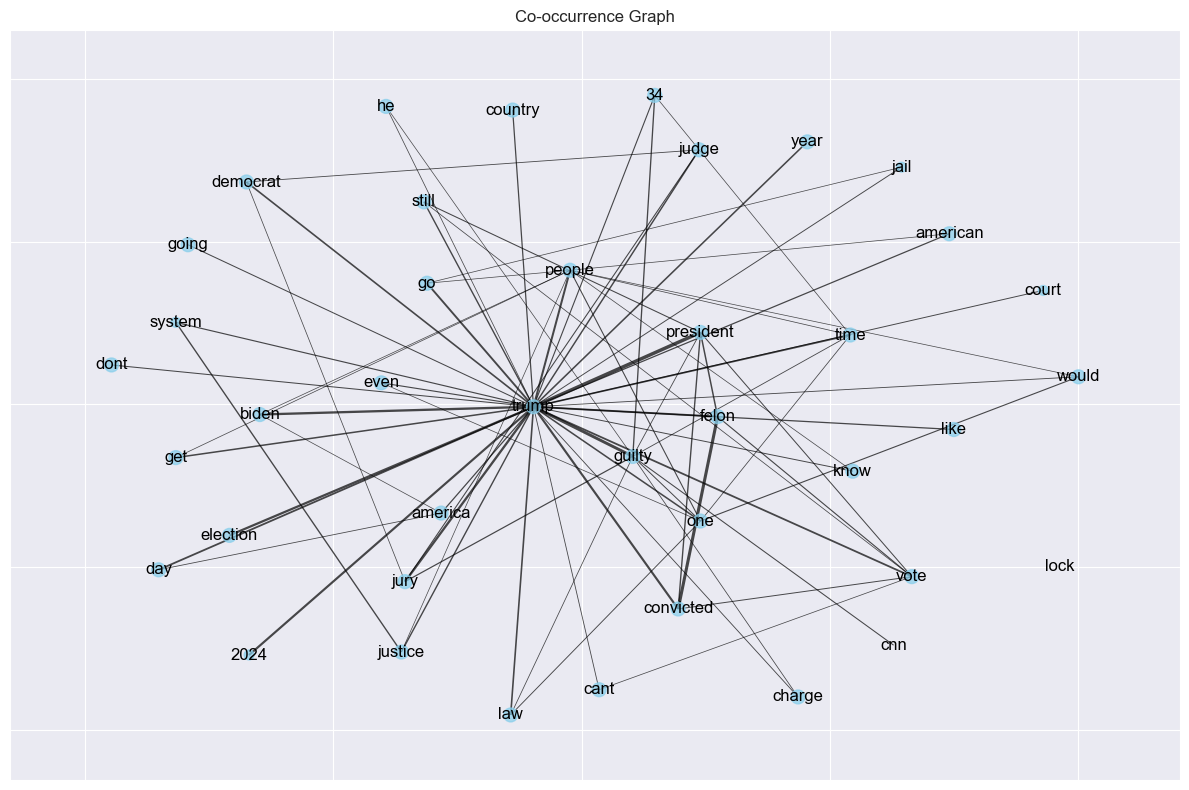

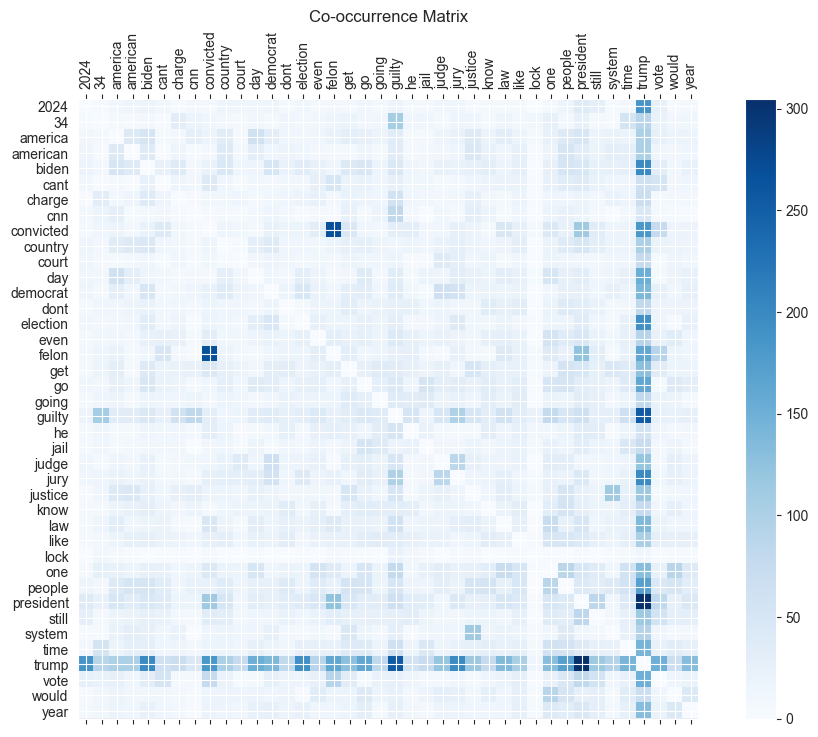

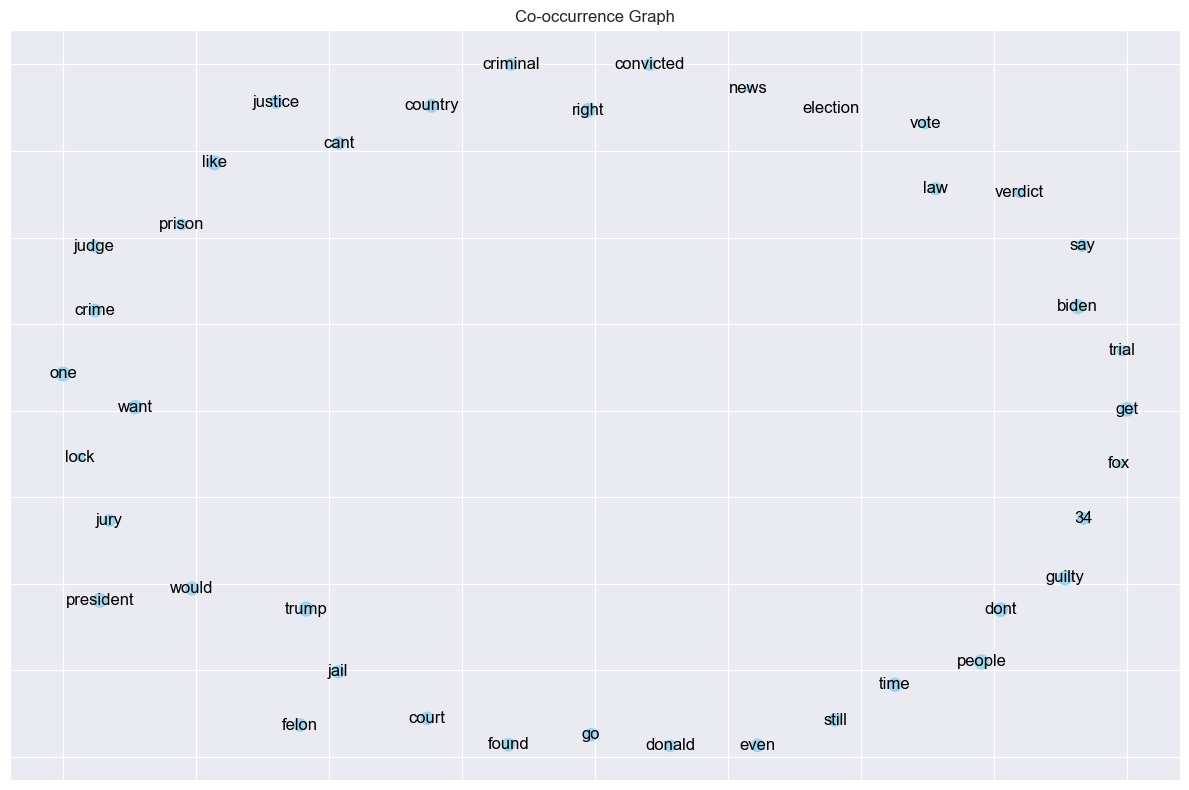

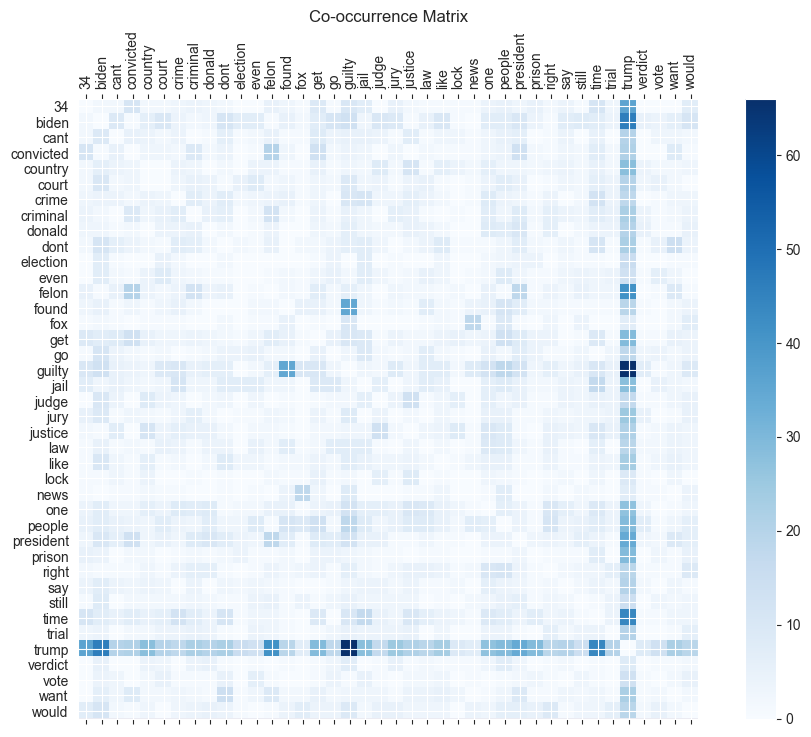

In [7]:
for tokenized_comment in tokenized_comments:
    comments = load_data_from_csv('../comments/trump_guilty/{}'.format(tokenized_comment))
    
    # Create co-occurrence matrix
    co_occurrence_matrix, words = create_co_occurrence_matrix(comments)

    # Create co-occurrence graph
    co_occurrence_graph = nx.Graph()

    # Add nodes to the graph
    for word in words:
        co_occurrence_graph.add_node(word)

    # Add weighted edges to the graph
    for i, word1 in enumerate(words):
        for j, word2 in enumerate(words):
            if i < j and co_occurrence_matrix[i, j] > 0:
                co_occurrence_graph.add_edge(word1, word2, weight=co_occurrence_matrix[i, j])

    # Visualize co-occurrence graph
    visualize_co_occurrence_graph(co_occurrence_graph, threshold=50)

    # Visualize co-occurrence matrix
    visualize_co_occurrence_matrix(co_occurrence_matrix, words)

In [8]:
import re

def clean(text):
    # Remove emojis, special symbols, and extra whitespaces
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Remove leading and trailing whitespaces
    cleaned_text = cleaned_text.strip()
    # Convert to lowercase
    cleaned_text = cleaned_text.lower()
    # Remove stopwords
    stop_words = set(nltk.corpus.stopwords.words('english'))
    cleaned_text = ' '.join([word for word in cleaned_text.split() if word not in stop_words])
    return cleaned_text

In [9]:
json_files

['The Wall Street Journal-Full Debate: Biden and Trump in the First 2024 Presidential Debate | WSJ.json',
 'CNN-The must-watch moments of the CNN Presidential Debate.json']

In [10]:
import os 
import json
import csv
import re


# most liked comments
# json_files = os.listdir('../comments/trump_guilty')
data_directory = '../original_data/debate/'
for json_file in json_files:
    with open(data_directory + json_file, 'r') as f:
        data = json.load(f)
    comments = data['video_comments']
    comments.sort(key=lambda x: x['likes_count'], reverse=True)
    file_name = json_file.removesuffix('.json')
    with open(f'../comments/debate/{file_name}_liked.csv', 'w', newline='') as liked_comments_file:
        writer = csv.writer(liked_comments_file)
        writer.writerow(['comment', 'likes_count'])
        for comment in comments:
            if comment['likes_count'] > 0:
                # clean the comment text
                cleaned_comment = clean_text(comment['comment_text'])
                writer.writerow([cleaned_comment, comment['likes_count']])